<a href="https://colab.research.google.com/github/Erica2222/FinalProject_DataScience/blob/main/DATASCIENCE_FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()



Saving sessions.csv.csv to sessions.csv (2).csv


In [5]:
import os
print(os.listdir())


['.config', 'sessions.csv (2).csv', 'sessions.csv.csv', 'sessions.csv (1).csv', 'drive', 'sample_data']


In [6]:
import pandas as pd
sessions = pd.read_csv(list(uploaded.keys())[0], encoding='ISO-8859-1')
sessions.head()



,date,session_id,category,activity_type,minutes,distance_km,notes
0,2025-11-18,20251118_gym_01,gym,gym,60.0,NaN,Lifting + running (incline bench 15lb superset...
1,2025-11-19,20251119_jog_01,cross_training,jog,33.0,NaN,Jog
2,2025-11-20,20251120_gym_01,gym,gym,60.0,NaN,Lower body + cardio circuit (DB RDL 10lb; DB s...
3,2025-11-24,20251124_gym_01,gym,gym,60.0,NaN,Cardio day + circuit (100m row; 50m ski; 100m ...
4,2025-11-26,20251126_gym_01,gym,gym,60.0,NaN,Upper body + core (incline bench 15lb; assiste...


In [7]:
sessions["date"] = pd.to_datetime(sessions["date"], errors="coerce")
sessions["minutes"] = pd.to_numeric(sessions["minutes"], errors="coerce")
sessions["distance_km"] = pd.to_numeric(sessions["distance_km"], errors="coerce")

print(sessions.dtypes)
print("\nMissing values:\n", sessions.isna().sum())


date             datetime64[ns]
session_id               object
category                 object
activity_type            object
minutes                 float64
distance_km             float64
notes                    object
dtype: object

Missing values:
 date              0
session_id        1
category          1
activity_type     1
minutes           5
distance_km      27
notes             1
dtype: int64


In [8]:
missing_rows = sessions[sessions[["session_id","category","activity_type"]].isna().any(axis=1)]
missing_rows


,date,session_id,category,activity_type,minutes,distance_km,notes
30,2026-01-17,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
sessions = sessions.dropna(subset=["session_id"]).reset_index(drop=True)
sessions.isna().sum()


,0
date,0
session_id,0
category,0
activity_type,0
minutes,4
distance_km,26
notes,0


In [10]:
iso = sessions["date"].dt.isocalendar()
sessions["year"] = iso["year"].astype(int)
sessions["week"] = iso["week"].astype(int)

weekly = sessions.groupby(["year", "week"]).agg(
    total_sessions=("session_id", "count"),
    total_minutes=("minutes", "sum"),
    gym_sessions=("category", lambda x: (x == "gym").sum()),
    gym_minutes=("minutes", lambda s: s[sessions.loc[s.index, "category"] == "gym"].sum()),
    cross_sessions=("category", lambda x: (x == "cross_training").sum()),
    cross_minutes=("minutes", lambda s: s[sessions.loc[s.index, "category"] == "cross_training"].sum()),
    activity_variety=("activity_type", "nunique")
).reset_index()

weekly["total_minutes"] = weekly["total_minutes"].fillna(0)
weekly["gym_minutes"] = weekly["gym_minutes"].fillna(0)
weekly["cross_minutes"] = weekly["cross_minutes"].fillna(0)

weekly


,year,week,total_sessions,total_minutes,gym_sessions,gym_minutes,cross_sessions,cross_minutes,activity_variety
0,2025,47,3,153.0,2,120.0,1,33.0,2
1,2025,48,3,180.0,3,180.0,0,0.0,1
2,2025,49,3,660.0,1,60.0,2,600.0,2
3,2025,50,6,330.0,2,120.0,4,210.0,3
4,2025,51,5,390.0,2,120.0,3,270.0,4
5,2025,52,3,240.0,0,0.0,3,240.0,3
6,2026,1,1,0.0,0,0.0,1,0.0,1
7,2026,2,3,180.0,3,180.0,0,0.0,1
8,2026,3,3,150.0,2,120.0,1,30.0,2


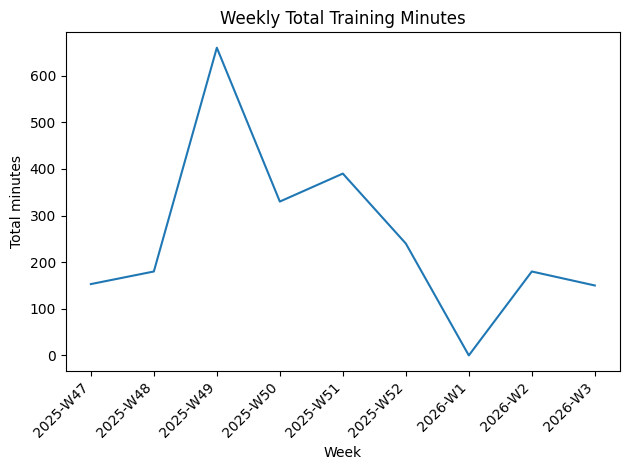

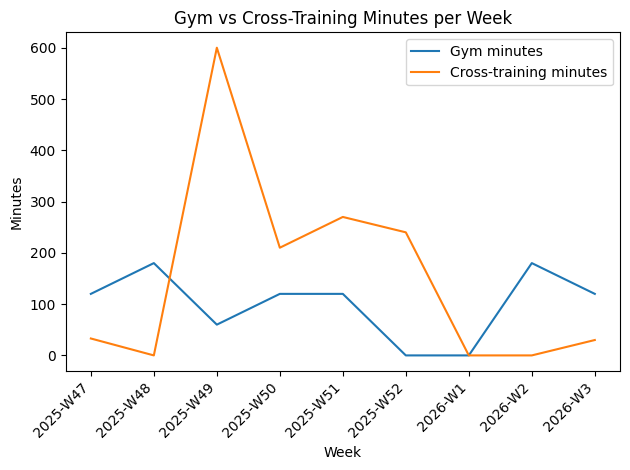

In [11]:
import matplotlib.pyplot as plt
weekly["year_week"] = weekly["year"].astype(str) + "-W" + weekly["week"].astype(str)

# Figure 1: Total training minutes per week
plt.figure()
plt.plot(weekly["year_week"], weekly["total_minutes"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Week")
plt.ylabel("Total minutes")
plt.title("Weekly Total Training Minutes")
plt.tight_layout()
plt.show()

# Figure 2: Gym vs Cross-training minutes per week
plt.figure()
plt.plot(weekly["year_week"], weekly["gym_minutes"], label="Gym minutes")
plt.plot(weekly["year_week"], weekly["cross_minutes"], label="Cross-training minutes")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Week")
plt.ylabel("Minutes")
plt.title("Gym vs Cross-Training Minutes per Week")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
from scipy import stats

# Pearson correlation: gym_sessions vs total_minutes
r, p = stats.pearsonr(weekly["gym_sessions"], weekly["total_minutes"])

print("Pearson r (gym_sessions vs total_minutes):", r)
print("p-value:", p)


Pearson r (gym_sessions vs total_minutes): -0.011239101837255166
p-value: 0.9771062997603946


In [13]:
import pandas as pd

strength = pd.DataFrame([
    # Nov 28 - Barbell Deadlift: "15kgs each side (Barbell included) 6 reps - 4 sets"
    #  total = 15*2 = 30 (no +20)
    {"date":"2025-11-28", "exercise":"Barbell Deadlift", "weight_kg_total":30, "reps":6, "sets":4,
     "source_note":"15kg each side (barbell included), 6 reps, 4 sets"},

    # Dec 9 - Barbell RDL: "10 Kg each side 6-8 reps - 4 sets"
    # standard bar +20
    {"date":"2025-12-09", "exercise":"Barbell RDL", "weight_kg_total":(10*2)+20, "reps":7, "sets":4,
     "source_note":"10kg each side, 6-8 reps, 4 sets"},

    # Dec 11 - Leg extensions 15 kgs 10-12 reps - 4 sets
    {"date":"2025-12-11", "exercise":"Leg Extension", "weight_kg_total":15, "reps":11, "sets":4,
     "source_note":"15kg, 10-12 reps, 4 sets"},

    # Dec 19 - Leg extensions 20 kgs 10-12 reps - 4 sets
    {"date":"2025-12-19", "exercise":"Leg Extension", "weight_kg_total":20, "reps":11, "sets":4,
     "source_note":"20kg, 10-12 reps, 4 sets"},

    # Jan 8 - Barbell RDL 10kg each side 8 reps - 4 sets
    {"date":"2026-01-08", "exercise":"Barbell RDL", "weight_kg_total":(10*2)+20, "reps":8, "sets":4,
     "source_note":"10kg each side, 8 reps, 4 sets"},

    # Jan 13 - Leg extensions 20 kgs 10-12 reps - 4 sets
    {"date":"2026-01-13", "exercise":"Leg Extension", "weight_kg_total":20, "reps":11, "sets":4,
     "source_note":"20kg, 10-12 reps, 4 sets"},
])

strength["date"] = pd.to_datetime(strength["date"])
strength


,date,exercise,weight_kg_total,reps,sets,source_note
0,2025-11-28,Barbell Deadlift,30,6,4,"15kg each side (barbell included), 6 reps, 4 sets"
1,2025-12-09,Barbell RDL,40,7,4,"10kg each side, 6-8 reps, 4 sets"
2,2025-12-11,Leg Extension,15,11,4,"15kg, 10-12 reps, 4 sets"
3,2025-12-19,Leg Extension,20,11,4,"20kg, 10-12 reps, 4 sets"
4,2026-01-08,Barbell RDL,40,8,4,"10kg each side, 8 reps, 4 sets"
5,2026-01-13,Leg Extension,20,11,4,"20kg, 10-12 reps, 4 sets"


In [14]:
strength.to_csv("strength.csv", index=False)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

strength = pd.read_csv("strength.csv")
strength["date"] = pd.to_datetime(strength["date"])

# Epley e1RM
strength["e1rm"] = strength["weight_kg_total"] * (1 + strength["reps"]/30)

strength.sort_values(["exercise", "date"], inplace=True)
strength


,date,exercise,weight_kg_total,reps,sets,source_note,e1rm
0,2025-11-28,Barbell Deadlift,30,6,4,"15kg each side (barbell included), 6 reps, 4 sets",36.000000
1,2025-12-09,Barbell RDL,40,7,4,"10kg each side, 6-8 reps, 4 sets",49.333333
4,2026-01-08,Barbell RDL,40,8,4,"10kg each side, 8 reps, 4 sets",50.666667
2,2025-12-11,Leg Extension,15,11,4,"15kg, 10-12 reps, 4 sets",20.500000
3,2025-12-19,Leg Extension,20,11,4,"20kg, 10-12 reps, 4 sets",27.333333
5,2026-01-13,Leg Extension,20,11,4,"20kg, 10-12 reps, 4 sets",27.333333


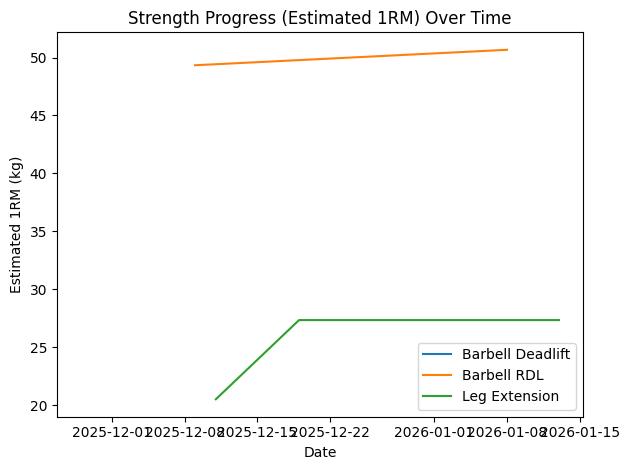

In [16]:
plt.figure()
for ex, df_ex in strength.groupby("exercise"):
    plt.plot(df_ex["date"], df_ex["e1rm"], label=ex)

plt.xlabel("Date")
plt.ylabel("Estimated 1RM (kg)")
plt.title("Strength Progress (Estimated 1RM) Over Time")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

data = weekly.copy()

median_minutes = data["total_minutes"].median()
data["high_training_week"] = (data["total_minutes"] >= median_minutes).astype(int)

feature_cols = ["gym_sessions","gym_minutes","cross_sessions","cross_minutes","activity_variety"]
X = data[feature_cols]
y = data["high_training_week"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train_s, y_train)

pred = clf.predict(X_test_s)

print("Median minutes:", median_minutes)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Median minutes: 180.0
Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.50      0.50         2

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3



In [18]:
weights = pd.DataFrame({
    "feature": feature_cols,
    "weight": clf.coef_[0]
}).sort_values("weight", ascending=False)

weights



,feature,weight
3,cross_minutes,0.663261
0,gym_sessions,0.529535
1,gym_minutes,0.529535
2,cross_sessions,0.104355
4,activity_variety,0.070842


In [19]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_s, y_train)

svm_pred = svm.predict(X_test_s)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

svm_weights = pd.DataFrame({
    "feature": feature_cols,
    "weight": svm.coef_[0]
}).sort_values("weight", ascending=False)

svm_weights


SVM Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



,feature,weight
3,cross_minutes,0.868872
0,gym_sessions,0.642460
1,gym_minutes,0.642460
2,cross_sessions,0.131940
4,activity_variety,-0.070683


In [20]:
merged = weights.merge(
    svm_weights, on="feature", suffixes=("_lr", "_svm")
)

merged["mutual_avg_weight"] = (merged["weight_lr"] + merged["weight_svm"]) / 2
merged = merged.sort_values("mutual_avg_weight", ascending=False)

merged


,feature,weight_lr,weight_svm,mutual_avg_weight
0,cross_minutes,0.663261,0.868872,0.766066
1,gym_sessions,0.529535,0.642460,0.585998
2,gym_minutes,0.529535,0.642460,0.585998
3,cross_sessions,0.104355,0.131940,0.118147
4,activity_variety,0.070842,-0.070683,0.000080


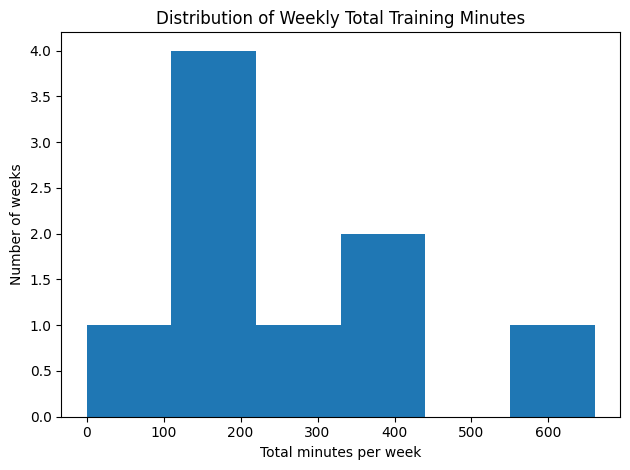

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(weekly["total_minutes"], bins=6)
plt.xlabel("Total minutes per week")
plt.ylabel("Number of weeks")
plt.title("Distribution of Weekly Total Training Minutes")
plt.tight_layout()
plt.show()


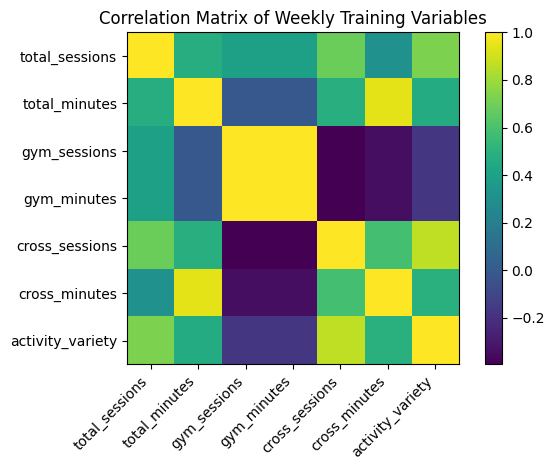

,total_sessions,total_minutes,gym_sessions,gym_minutes,cross_sessions,cross_minutes,activity_variety
total_sessions,1.000000,0.471856,0.395285,0.395285,0.687500,0.311364,0.726722
total_minutes,0.471856,1.000000,-0.011239,-0.011239,0.480741,0.942829,0.461986
gym_sessions,0.395285,-0.011239,1.000000,1.000000,-0.395285,-0.343853,-0.176777
gym_minutes,0.395285,-0.011239,1.000000,1.000000,-0.395285,-0.343853,-0.176777
cross_sessions,0.687500,0.480741,-0.395285,-0.395285,1.000000,0.583203,0.866476
cross_minutes,0.311364,0.942829,-0.343853,-0.343853,0.583203,1.000000,0.492762
activity_variety,0.726722,0.461986,-0.176777,-0.176777,0.866476,0.492762,1.000000


In [22]:
corr_cols = ["total_sessions","total_minutes","gym_sessions","gym_minutes",
             "cross_sessions","cross_minutes","activity_variety"]

corr = weekly[corr_cols].corr()

plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation Matrix of Weekly Training Variables")
plt.colorbar()
plt.tight_layout()
plt.show()

corr


In [23]:
stats_table = weekly[corr_cols].agg(["mean","median","std","min","max"]).T
stats_table = stats_table.round(2)
stats_table


,mean,median,std,min,max
total_sessions,3.33,3.0,1.41,1.0,6.0
total_minutes,253.67,180.0,189.01,0.0,660.0
gym_sessions,1.67,2.0,1.12,0.0,3.0
gym_minutes,100.00,120.0,67.08,0.0,180.0
cross_sessions,1.67,1.0,1.41,0.0,4.0
cross_minutes,153.67,33.0,201.27,0.0,600.0
activity_variety,2.11,2.0,1.05,1.0,4.0


In [24]:
pearson_table = pd.DataFrame([{
    "Test": "Pearson correlation",
    "Variable 1": "gym_sessions",
    "Variable 2": "total_minutes",
    "r": round(r, 3),
    "p_value": round(p, 3)
}])
pearson_table


,Test,Variable 1,Variable 2,r,p_value
0,Pearson correlation,gym_sessions,total_minutes,-0.011,0.977


In [25]:
final_weights = merged.copy()
final_weights = final_weights.rename(columns={
    "weight_lr": "LR_weight",
    "weight_svm": "SVM_weight"
})
final_weights = final_weights[["feature","LR_weight","SVM_weight","mutual_avg_weight"]]
final_weights = final_weights.round(3)
final_weights


,feature,LR_weight,SVM_weight,mutual_avg_weight
0,cross_minutes,0.663,0.869,0.766
1,gym_sessions,0.530,0.642,0.586
2,gym_minutes,0.530,0.642,0.586
3,cross_sessions,0.104,0.132,0.118
4,activity_variety,0.071,-0.071,0.000
